### Import Required Dependencies

In [1]:
import os
import io
import time
import subprocess
import numpy as np
import pandas as pd

import seaborn as sns
sns.set()

from pathlib2 import Path
from zipfile import ZipFile
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn import metrics
from sklearn.metrics import confusion_matrix

import warnings
warnings.filterwarnings('ignore')

import boto3
import sagemaker
from sagemaker.serializers import CSVSerializer
from sagemaker.amazon.amazon_estimator import RecordSet

%matplotlib inline

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/ec2-user/.config/sagemaker/config.yaml


### Required Instance Type

In [2]:
instance_type = 'ml.m4.xlarge'

### Uploading and Preparing Data

After creating a notebook in Amazon Sage Maker, I uploaded the files that I prepared in part A but as compressed files. The reason for compression is to speed up the upload process, as total size of the both the files is above 1GB, and the compressed file is around 18MB.

I will unzip the files oncloud and then will use the files in my analysis.

In [3]:
def zip2csv(zipFile_name , file_path):
    """
    Extract csv from zip files
    zipFile_name: name of the zip file
    file_path : name of the folder to store csv
    """

    try:
        with ZipFile(zipFile_name, 'r') as z: 
            print(f'Extracting {zipFile_name} ') 
            z.extractall(path=file_path) 
    except:
        print(f'zip2csv failed for {zipFile_name}')

In [4]:
zip2csv("./data.zip", "./")
print("Files Extracted")

Extracting ./data.zip 
Files Extracted


### Train-test Split Helper Function

In [5]:
from sklearn.model_selection import train_test_split
def split_data(data):
    train, test_and_validate = train_test_split(data, test_size=0.3, random_state=42, stratify=data['target'])
    test, validate = train_test_split(test_and_validate, test_size=0.5, random_state=42, stratify=test_and_validate['target'])
    return train, validate, test

### Get Bucket Assigned To NoteBook

In [6]:
s3_client = boto3.client('s3')

response = s3_client.list_buckets()
buckets = [bucket['Name'] for bucket in response['Buckets']]
print("All Available Buckets:", buckets)
bucket = buckets[0]
print("Our Current Bucket is: ", bucket)

All Available Buckets: ['c135321a3429026l8207923t1w47111283793-flightbucket-vreapxxajllg', 'sagemaker-us-east-1-471112837934']
Our Current Bucket is:  c135321a3429026l8207923t1w47111283793-flightbucket-vreapxxajllg


### Upload Data to S3 Helper Function

In [7]:
s3_resource = boto3.Session().resource('s3')
def upload_s3_csv(prefix, filename, folder, dataframe):
    csv_buffer = io.StringIO()
    dataframe.to_csv(csv_buffer, header=False, index=False)
    s3_resource.Bucket(bucket).Object(os.path.join(prefix, folder, filename)).put(Body = csv_buffer.getvalue())

### Confusion Matrix Plotting Helper Function

In [8]:
def plot_confusion_matrix(test_labels, target_predicted):
    matrix = confusion_matrix(test_labels, target_predicted)
    df_confusion = pd.DataFrame(matrix)
    colormap = sns.color_palette("BrBG", 10)
    sns.heatmap(df_confusion, annot=True, fmt='.2f', cbar=None, cmap=colormap)
    plt.title("Confusion Matrix")
    plt.tight_layout()
    plt.ylabel("True Class")
    plt.xlabel("Predicted Class")
    plt.show()


### ROC Plotting Helper Function

In [9]:
def plot_roc(test_labels, target_predicted, threshold=0.5):
    binary_predictions = (target_predicted >= threshold).astype(int)
    TN, FP, FN, TP = confusion_matrix(test_labels, binary_predictions).ravel()
    Sensitivity = float(TP) / (TP + FN) * 100
    Specificity = float(TN) / (TN + FP) * 100
    Precision = float(TP) / (TP + FP) * 100
    NPV = float(TN) / (TN + FN) * 100
    FPR = float(FP) / (FP + TN) * 100
    FNR = float(FN) / (TP + FN) * 100
    FDR = float(FP) / (TP + FP) * 100
    ACC = float(TP + TN) / (TP + FP + FN + TN) * 100
    print("Sensitivity or TPR:", Sensitivity, "%")
    print("Specificity or TNR:", Specificity, "%")
    print("Precision:", Precision, "%")
    print("Negative Predictive Value:", NPV, "%")
    print("False Positive Rate:", FPR, "%")
    print("False Negative Rate:", FNR, "%")
    print("False Discovery Rate:", FDR, "%")
    print("Accuracy:", ACC, "%")

    auc_score = metrics.roc_auc_score(test_labels, target_predicted)
    print("Validation AUC:", auc_score)
    
    fpr, tpr, thresholds = metrics.roc_curve(test_labels, target_predicted)
    roc_auc = metrics.auc(fpr, tpr)

    # Plot ROC curve
    plt.figure()
    plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")

    # Create the axis of thresholds (scores)
    ax2 = plt.gca().twinx()
    ax2.plot(fpr, thresholds, markeredgecolor='r', linestyle='dashed', color='r')
    ax2.set_ylabel('Threshold', color='r')
    ax2.set_ylim([0, 1])
    ax2.set_xlim([fpr[0], fpr[-1]])

    plt.show()

## Starting Linear Estimator Analysis On `combined_csv_v1.csv`

### Loading combined_csv_v1.csv Innto Pandas DataFrame

In [10]:
df1 = pd.read_csv("./combined_csv_v1.csv")
df1.head()

,target,Distance,Quarter_2,Quarter_3,Quarter_4,Month_2,Month_3,Month_4,Month_5,Month_6,...,Dest_DEN,Dest_DFW,Dest_IAH,Dest_LAX,Dest_ORD,Dest_PHX,Dest_SFO,DepHourofDay_bucket_evening,DepHourofDay_bucket_morning,DepHourofDay_bucket_night
0,0.0,689.0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,1
1,0.0,731.0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
2,0.0,1199.0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,1
3,0.0,1587.0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,1,0,0
4,0.0,1587.0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0


### Splitting combined_csv_v1.csv data into training, validation, and testing sets

In [11]:
train_v1, validate_v1, test_v1 = split_data(df1)
print(train_v1['target'].value_counts())
print(test_v1['target'].value_counts())
print(validate_v1['target'].value_counts())

0.0    904581
1.0    240332
Name: target, dtype: int64
0.0    193838
1.0     51500
Name: target, dtype: int64
0.0    193839
1.0     51500
Name: target, dtype: int64


### First Classification Model Instance

In [12]:
classifier_estimator = sagemaker.LinearLearner(
    role = sagemaker.get_execution_role(),
    instance_count=1,
    instance_type=instance_type,
    predictor_type='binary_classifier',
    binary_classifier_model_selection_criteria = 'cross_entropy_loss'
)

### Converts first classifier data into a SageMaker RecordSet format

In [13]:
train_records_v1 = classifier_estimator.record_set(train_v1.values[:, 1:].astype(np.float32), train_v1.values[:, 0].astype(np.float32), channel='train')
val_records_v1 = classifier_estimator.record_set(validate_v1.values[:, 1:].astype(np.float32), validate_v1.values[:, 0].astype(np.float32), channel='validation')
test_records_v1 = classifier_estimator.record_set(test_v1.values[:, 1:].astype(np.float32), test_v1.values[:, 0].astype(np.float32), channel='test')

### Initialize First LinearLearner Classifier Training Job

In [14]:
classifier_estimator.fit([train_records_v1,val_records_v1,test_records_v1], logs=False)

INFO:sagemaker.image_uris:Same images used for training and inference. Defaulting to image scope: inference.
INFO:sagemaker.image_uris:Ignoring unnecessary instance type: None.
INFO:sagemaker:Creating training-job with name: linear-learner-2024-11-03-01-19-51-640



2024-11-03 01:19:53 Starting - Starting the training job..
2024-11-03 01:20:08 Starting - Preparing the instances for training...
2024-11-03 01:20:31 Downloading - Downloading input data.......
2024-11-03 01:21:12 Downloading - Downloading the training image............
2024-11-03 01:22:18 Training - Training image download completed. Training in progress.......................................
2024-11-03 01:25:34 Uploading - Uploading generated training model.
2024-11-03 01:25:42 Completed - Training job completed


### First Linearlearner CLassifier Model Evaluation

In [15]:
sagemaker.analytics.TrainingJobAnalytics(
    classifier_estimator._current_job_name, 
    metric_names = ['test:objective_loss', 'test:binary_f_beta', 'test:precision', 'test:recall']
).dataframe()

,timestamp,metric_name,value
0,0.0,test:objective_loss,0.495700
1,0.0,test:binary_f_beta,0.005253
2,0.0,test:precision,0.483986
3,0.0,test:recall,0.002641


### Batch LinearLearner Prediction Helper Output Helper Function

In [16]:
def batch_linear_predict(prefix, test_data, estimator):
    batch_X = test_data.iloc[:,1:];
    batch_X_file='batch-in.csv'
    upload_s3_csv(prefix, batch_X_file, 'batch-in', batch_X)

    batch_output = "s3://{}/{}/batch-out/".format(bucket,prefix)
    batch_input = "s3://{}/{}/batch-in/{}".format(bucket,prefix,batch_X_file)

    classifier_transformer = estimator.transformer(
        instance_count=1,
        instance_type='ml.m4.xlarge',
        strategy='MultiRecord',
        assemble_with='Line',
        output_path=batch_output,
    )

    classifier_transformer.transform(
        data=batch_input,
        data_type='S3Prefix',
        content_type='text/csv',
        split_type='Line',
    )

    classifier_transformer.wait()
    s3 = boto3.client('s3')
    obj = s3.get_object(Bucket=bucket, Key="{}/batch-out/{}".format(prefix,'batch-in.csv.out'))
    target_predicted_df = pd.read_json(io.BytesIO(obj['Body'].read()),orient="records",lines=True)
    return test_data.iloc[:,0], target_predicted_df.iloc[:,0]

### First LinearLearner Prediction Output

In [17]:
prefix = "linear_learner_v1"
test_labels_v1, target_predicted_v1 = batch_linear_predict(prefix, test_v1, classifier_estimator)

INFO:sagemaker.image_uris:Same images used for training and inference. Defaulting to image scope: inference.
INFO:sagemaker.image_uris:Ignoring unnecessary instance type: None.
INFO:sagemaker:Creating model with name: linear-learner-2024-11-03-01-25-48-923
INFO:sagemaker:Creating transform job with name: linear-learner-2024-11-03-01-25-49-510


..........................................
Docker entrypoint called with argument(s): serve
Running default environment configuration script
[11/03/2024 01:32:50 INFO 140181034751808] Memory profiler is not enabled by the environment variable ENABLE_PROFILER.
Docker entrypoint called with argument(s): serve
Running default environment configuration script
[11/03/2024 01:32:50 INFO 140181034751808] Memory profiler is not enabled by the environment variable ENABLE_PROFILER.
/opt/amazon/lib/python3.8/site-packages/mxnet/model.py:97: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if num_device is 1 and 'dist' not in kvstore:
/opt/amazon/lib/python3.8/site-packages/mxnet/model.py:97: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if num_device is 1 and 'dist' not in kvstore:
/opt/amazon/lib/python3.8/site-packages/scipy/optimize/_shgo.py:495: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if cons['type'] is 'ineq':
/opt/amazon/lib/python3.8/site-packages/scipy/

### Generating Confusion Matrix Of First LinearLearner Model

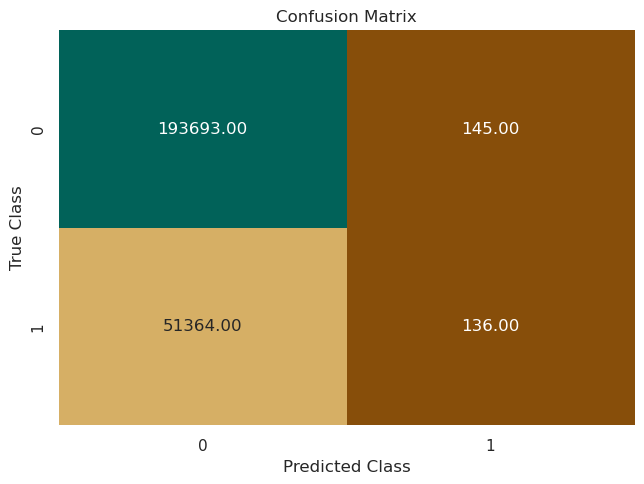

In [18]:
plot_confusion_matrix(test_labels_v1, target_predicted_v1)

### Generating ROC Of First LinearLearner Model

Sensitivity or TPR: 0.26407766990291265 %
Specificity or TNR: 99.92519526615008 %
Precision: 48.39857651245551 %
Negative Predictive Value: 79.03997845399233 %
False Positive Rate: 0.07480473384991591 %
False Negative Rate: 99.73592233009708 %
False Discovery Rate: 51.60142348754449 %
Accuracy: 79.00488305928963 %
Validation AUC: 0.5009463646802649


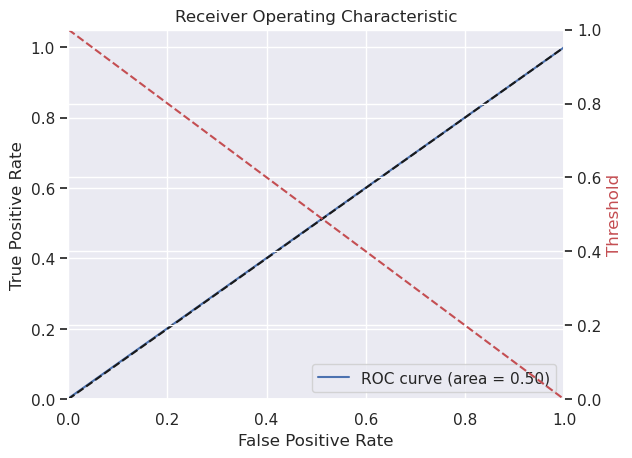

In [19]:
plot_roc(test_labels_v1, target_predicted_v1)

To plot the confusion matrix, call the `plot_confusion_matrix` function on the `test_labels` and the `target_predicted` data from your batch job:

## Starting Linear Estimator Analysis On `combined_csv_v2.csv`

### Loading combined_csv_v2.csv Innto Pandas DataFrame

In [20]:
df2 = pd.read_csv("combined_csv_v2.csv")
df2.head()

,target,Distance,DepHourofDay,AWND_O,PRCP_O,TAVG_O,AWND_D,PRCP_D,TAVG_D,SNOW_O,...,Origin_SFO,Dest_CLT,Dest_DEN,Dest_DFW,Dest_IAH,Dest_LAX,Dest_ORD,Dest_PHX,Dest_SFO,is_holiday_1
0,0.0,689.0,21,33,0,54.0,30,0,130.0,0.0,...,0,0,0,0,1,0,0,0,0,0
1,0.0,731.0,9,39,0,136.0,33,0,54.0,0.0,...,0,0,0,0,0,0,0,0,0,0
2,0.0,1199.0,18,33,0,54.0,77,0,68.0,0.0,...,0,0,1,0,0,0,0,0,0,0
3,0.0,1587.0,16,33,0,54.0,20,0,165.0,0.0,...,0,0,0,0,0,0,0,1,0,0
4,0.0,1587.0,7,20,0,165.0,33,0,54.0,0.0,...,0,0,0,0,0,0,0,0,0,0


### Splitting combined_csv_v2.csv data into training, validation, and testing sets

In [21]:
train_v2, test_v2, validate_v2 = split_data(df2)
print(train_v2['target'].value_counts())
print(test_v2['target'].value_counts())
print(validate_v2['target'].value_counts())

0.0    904581
1.0    240332
Name: target, dtype: int64
0.0    193839
1.0     51500
Name: target, dtype: int64
0.0    193838
1.0     51500
Name: target, dtype: int64


### Second Classification Model Instance

In [22]:
classifier_estimator2 = sagemaker.LinearLearner(
    role=sagemaker.get_execution_role(),
    instance_count=1,
    instance_type='ml.m4.xlarge',
    predictor_type='binary_classifier',
    binary_classifier_model_selection_criteria = 'cross_entropy_loss'
)

### Converts Second classifier data into a SageMaker RecordSet format

In [23]:
train_records_v2 = classifier_estimator2.record_set(train_v2.values[:, 1:].astype(np.float32), train_v2.values[:, 0].astype(np.float32), channel='train')
val_records_v2 = classifier_estimator2.record_set(validate_v2.values[:, 1:].astype(np.float32), validate_v2.values[:, 0].astype(np.float32), channel='validation')
test_records_v2 = classifier_estimator2.record_set(test_v2.values[:, 1:].astype(np.float32), test_v2.values[:, 0].astype(np.float32), channel='test')

### Initialize Second LinearLearner Classifier Training Job

In [24]:
classifier_estimator2.fit([train_records_v2, val_records_v2, test_records_v2], logs=False)

INFO:sagemaker.image_uris:Same images used for training and inference. Defaulting to image scope: inference.
INFO:sagemaker.image_uris:Ignoring unnecessary instance type: None.
INFO:sagemaker.image_uris:Same images used for training and inference. Defaulting to image scope: inference.
INFO:sagemaker.image_uris:Ignoring unnecessary instance type: None.
INFO:sagemaker:Creating training-job with name: linear-learner-2024-11-03-01-34-37-810



2024-11-03 01:34:38 Starting - Starting the training job.
2024-11-03 01:34:52 Starting - Preparing the instances for training......
2024-11-03 01:35:25 Downloading - Downloading input data.......
2024-11-03 01:36:05 Downloading - Downloading the training image............
2024-11-03 01:37:11 Training - Training image download completed. Training in progress.....................................
2024-11-03 01:40:17 Uploading - Uploading generated training model.
2024-11-03 01:40:30 Completed - Training job completed


### Second LinearLearner Prediction Output

In [25]:
def batch_linear_predict(prefix, test_data, estimator):
    batch_X = test_data.iloc[:,1:];
    batch_X_file='batch-in.csv'
    upload_s3_csv(prefix, batch_X_file, 'batch-in', batch_X)

    batch_output = "s3://{}/{}/batch-out/".format(bucket,prefix)
    batch_input = "s3://{}/{}/batch-in/{}".format(bucket,prefix,batch_X_file)

    classifier_transformer = estimator.transformer(
        instance_count=1,
        instance_type='ml.m4.xlarge',
        strategy='MultiRecord',
        assemble_with='Line',
        output_path=batch_output,
    )

    classifier_transformer.transform(
        data=batch_input,
        data_type='S3Prefix',
        content_type='text/csv',
        split_type='Line',
    )

    classifier_transformer.wait()
    s3 = boto3.client('s3')
    obj = s3.get_object(Bucket=bucket, Key="{}/batch-out/{}".format(prefix,'batch-in.csv.out'))
    target_predicted_df = pd.read_json(io.BytesIO(obj['Body'].read()),orient="records",lines=True)
    return test_data.iloc[:,0], target_predicted_df.iloc[:,0]

In [26]:
prefix = "linear_learner_v2"
test_labels_v2, target_predicted_v2 = batch_linear_predict(prefix, test_v2, classifier_estimator2)

INFO:sagemaker.image_uris:Same images used for training and inference. Defaulting to image scope: inference.
INFO:sagemaker.image_uris:Ignoring unnecessary instance type: None.
INFO:sagemaker:Creating model with name: linear-learner-2024-11-03-01-40-35-343
INFO:sagemaker:Creating transform job with name: linear-learner-2024-11-03-01-40-35-948


..............................................Docker entrypoint called with argument(s): serve
Running default environment configuration script
[11/03/2024 01:48:21 INFO 139812327216960] Memory profiler is not enabled by the environment variable ENABLE_PROFILER.
/opt/amazon/lib/python3.8/site-packages/mxnet/model.py:97: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if num_device is 1 and 'dist' not in kvstore:
/opt/amazon/lib/python3.8/site-packages/scipy/optimize/_shgo.py:495: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if cons['type'] is 'ineq':
/opt/amazon/lib/python3.8/site-packages/scipy/optimize/_shgo.py:743: SyntaxWarning: "is not" with a literal. Did you mean "!="?
  if len(self.X_min) is not 0:
[11/03/2024 01:48:25 WARNING 139812327216960] Loggers have already been setup.
[11/03/2024 01:48:25 INFO 139812327216960] loaded entry point class algorithm.serve.server_config:config_api
[11/03/2024 01:48:25 INFO 139812327216960] loading entry points
[11/03/2024

In [27]:
### Generating Confusion Matrix Of Second LinearLearner Model

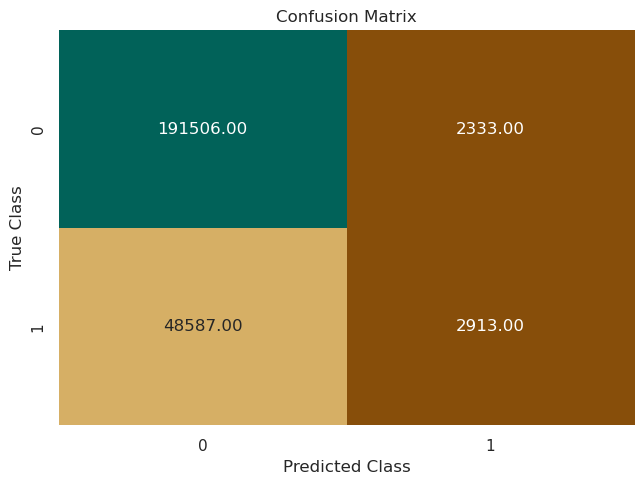

In [28]:
plot_confusion_matrix(test_labels_v2, target_predicted_v2)

In [29]:
### Generating ROC Of Second LinearLearner Model

Sensitivity or TPR: 5.656310679611651 %
Specificity or TNR: 98.79642383627649 %
Precision: 55.5280213495997 %
Negative Predictive Value: 79.7632584040351 %
False Positive Rate: 1.2035761637235025 %
False Negative Rate: 94.34368932038835 %
False Discovery Rate: 44.47197865040031 %
Accuracy: 79.2450446117413 %
Validation AUC: 0.5222636725794407


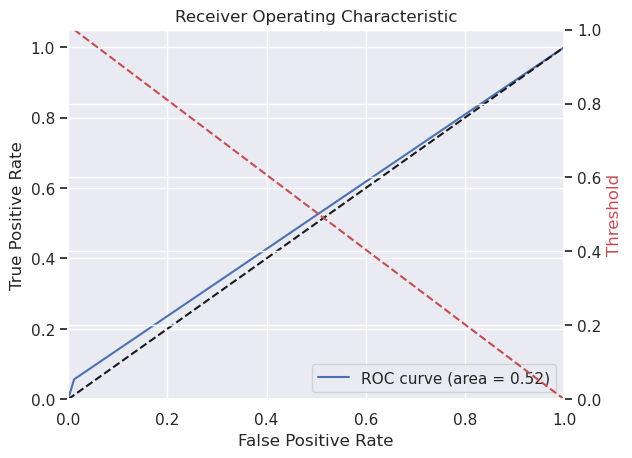

In [30]:
plot_roc(test_labels_v2, target_predicted_v2)

### XGBoost model

In [31]:
prefix='flight-xgb'
train_file='flight_train.csv'
test_file='flight_test.csv'
validate_file='flight_validate.csv'

upload_s3_csv(prefix, train_file, 'train', train_v1)
upload_s3_csv(prefix, test_file, 'test', test_v1)
upload_s3_csv(prefix, validate_file, 'validate', validate_v1)

In [32]:
train_channel = sagemaker.inputs.TrainingInput(
    "s3://{}/{}/train/".format(bucket,prefix,train_file),
    content_type='text/csv')

validate_channel = sagemaker.inputs.TrainingInput(
    "s3://{}/{}/validate/".format(bucket,prefix,validate_file),
    content_type='text/csv')

data_channels = {'train': train_channel, 'validation': validate_channel}

In [33]:
from sagemaker.image_uris import retrieve
container = retrieve('xgboost',boto3.Session().region_name,'1.0-1')

INFO:sagemaker.image_uris:Defaulting to only available Python version: py3
INFO:sagemaker.image_uris:Defaulting to only supported image scope: cpu.


In [34]:
sess = sagemaker.Session()
s3_output_location="s3://{}/{}/output/".format(bucket,prefix)

xgb = sagemaker.estimator.Estimator(container,
                                    role = sagemaker.get_execution_role(), 
                                    instance_count=1, 
                                    instance_type=instance_type,
                                    output_path=s3_output_location,
                                    sagemaker_session=sess)
xgb.set_hyperparameters(max_depth=5,
                        eta=0.2,
                        gamma=4,
                        min_child_weight=6,
                        subsample=0.8,
                        silent=0,
                        objective='binary:logistic',
                        eval_metric = "auc", 
                        num_round=100)

xgb.fit(inputs=data_channels)

INFO:sagemaker:Creating training-job with name: sagemaker-xgboost-2024-11-03-01-49-32-781


2024-11-03 01:49:34 Starting - Starting the training job...
2024-11-03 01:49:49 Starting - Preparing the instances for training...
2024-11-03 01:50:19 Downloading - Downloading input data...
2024-11-03 01:50:54 Downloading - Downloading the training image......
2024-11-03 01:51:45 Training - Training image download completed. Training in progress.[2024-11-03 01:51:54.183 ip-10-0-245-241.ec2.internal:7 INFO utils.py:27] RULE_JOB_STOP_SIGNAL_FILENAME: None
INFO:sagemaker-containers:Imported framework sagemaker_xgboost_container.training
INFO:sagemaker-containers:Failed to parse hyperparameter eval_metric value auc to Json.
Returning the value itself
INFO:sagemaker-containers:Failed to parse hyperparameter objective value binary:logistic to Json.
Returning the value itself
INFO:sagemaker-containers:No GPUs detected (normal if no gpus installed)
INFO:sagemaker_xgboost_container.training:Running XGBoost Sagemaker in algorithm mode
INFO:root:Determined delimiter of CSV input is ','
INFO:root

In [35]:
batch_X = test_v1.iloc[:,1:];
batch_X_file='batch-in.csv'
upload_s3_csv(prefix, batch_X_file, 'batch-in', batch_X)
batch_output = "s3://{}/{}/batch-out/".format(bucket,prefix)
batch_input = "s3://{}/{}/batch-in/{}".format(bucket,prefix,batch_X_file)

xgb_transformer = xgb.transformer(
    instance_count=1,
    instance_type=instance_type,
    strategy='MultiRecord',
    assemble_with='Line',
    output_path=batch_output
)

xgb_transformer.transform(
    data=batch_input,
    data_type='S3Prefix',
    content_type='text/csv',
    split_type='Line'
)

xgb_transformer.wait()

INFO:sagemaker:Creating model with name: sagemaker-xgboost-2024-11-03-01-55-25-464
INFO:sagemaker:Creating transform job with name: sagemaker-xgboost-2024-11-03-01-55-26-156


....................................[2024-11-03:02:01:25:INFO] No GPUs detected (normal if no gpus installed)
[2024-11-03:02:01:25:INFO] No GPUs detected (normal if no gpus installed)
[2024-11-03:02:01:25:INFO] nginx config: 
worker_processes auto;
daemon off;
pid /tmp/nginx.pid;
error_log  /dev/stderr;
worker_rlimit_nofile 4096;
events {
  worker_connections 2048;
}
http {
  include /etc/nginx/mime.types;
  default_type application/octet-stream;
  access_log /dev/stdout combined;
  upstream gunicorn {
    server unix:/tmp/gunicorn.sock;
  }
  server {
    listen 8080 deferred;
    client_max_body_size 0;
    keepalive_timeout 3;
    location ~ ^/(ping|invocations|execution-parameters) {
      proxy_set_header X-Forwarded-For $proxy_add_x_forwarded_for;
      proxy_set_header Host $http_host;
      proxy_redirect off;
      proxy_read_timeout 60s;
      proxy_pass http://gunicorn;
    }
    location / {
      return 404 "{}";
    }
  }
}
[2024-11-03 02:01:25 +0000] [19] [INFO] Starting

In [36]:
s3 = boto3.client('s3')
obj = s3.get_object(Bucket=bucket, Key="{}/batch-out/{}".format(prefix,'batch-in.csv.out'))
target_predicted = pd.read_csv(io.BytesIO(obj['Body'].read()),sep=',',names=['target'])
test_labels = test_v1.iloc[:,0]

In [37]:
print(target_predicted.head())

def binary_convert(x):
    threshold = 0.55
    if x > threshold:
        return 1
    else:
        return 0

target_predicted['target'] = target_predicted['target'].apply(binary_convert)
test_labels = test_v1.iloc[:,0]
print(target_predicted.head())

     target
0  0.165263
1  0.197633
2  0.130694
3  0.095515
4  0.149932
   target
0       0
1       0
2       0
3       0
4       0


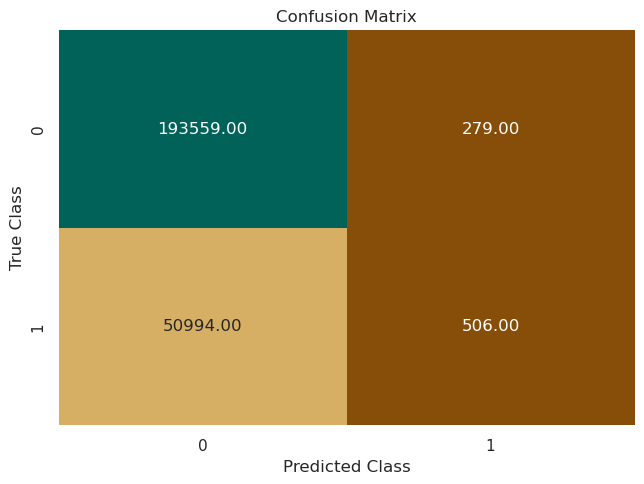

In [38]:
plot_confusion_matrix(test_labels, target_predicted)

Sensitivity or TPR: 5.656310679611651 %
Specificity or TNR: 98.79642383627649 %
Precision: 55.5280213495997 %
Negative Predictive Value: 79.7632584040351 %
False Positive Rate: 1.2035761637235025 %
False Negative Rate: 94.34368932038835 %
False Discovery Rate: 44.47197865040031 %
Accuracy: 79.2450446117413 %
Validation AUC: 0.5222636725794407


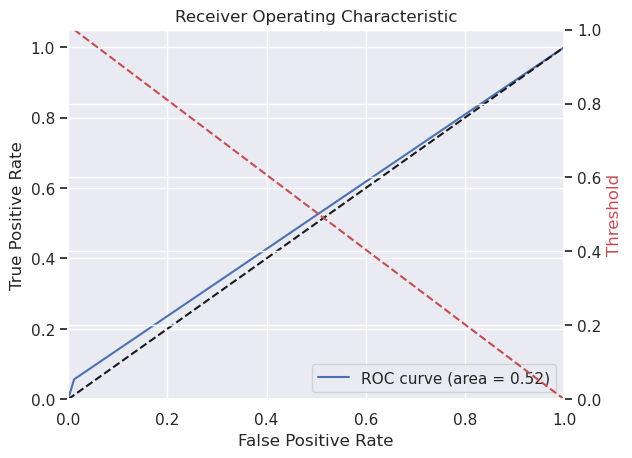

In [39]:
plot_roc(test_labels_v2, target_predicted_v2)

# XGBoost model 2

In [46]:
prefix='flight-xgb-2'
train_file='flight_train_2.csv'
test_file='flight_test_2.csv'
validate_file='flight_validate_2.csv'

upload_s3_csv(prefix, train_file, 'train', train_v2)
upload_s3_csv(prefix, test_file, 'test', test_v2)
upload_s3_csv(prefix, validate_file, 'validate', validate_v2)

In [47]:
train_channel = sagemaker.inputs.TrainingInput(
    "s3://{}/{}/train/".format(bucket,prefix,train_file),
    content_type='text/csv')

validate_channel = sagemaker.inputs.TrainingInput(
    "s3://{}/{}/validate/".format(bucket,prefix,validate_file),
    content_type='text/csv')

data_channels = {'train': train_channel, 'validation': validate_channel}

In [48]:
from sagemaker.image_uris import retrieve
container = retrieve('xgboost',boto3.Session().region_name,'1.0-1')

INFO:sagemaker.image_uris:Defaulting to only available Python version: py3
INFO:sagemaker.image_uris:Defaulting to only supported image scope: cpu.


In [49]:
sess = sagemaker.Session()
s3_output_location="s3://{}/{}/output/".format(bucket,prefix)

xgb = sagemaker.estimator.Estimator(container,
                                    role = sagemaker.get_execution_role(), 
                                    instance_count=1, 
                                    instance_type=instance_type,
                                    output_path=s3_output_location,
                                    sagemaker_session=sess)
xgb.set_hyperparameters(max_depth=5,
                        eta=0.2,
                        gamma=4,
                        min_child_weight=6,
                        subsample=0.8,
                        silent=0,
                        objective='binary:logistic',
                        eval_metric = "auc", 
                        num_round=100)

xgb.fit(inputs=data_channels)

INFO:sagemaker:Creating training-job with name: sagemaker-xgboost-2024-11-03-02-31-40-413


2024-11-03 02:31:41 Starting - Starting the training job...
2024-11-03 02:31:56 Starting - Preparing the instances for training...
2024-11-03 02:32:26 Downloading - Downloading input data...
2024-11-03 02:33:07 Downloading - Downloading the training image......
2024-11-03 02:33:53 Training - Training image download completed. Training in progress.[2024-11-03 02:34:02.948 ip-10-0-164-6.ec2.internal:7 INFO utils.py:27] RULE_JOB_STOP_SIGNAL_FILENAME: None
INFO:sagemaker-containers:Imported framework sagemaker_xgboost_container.training
INFO:sagemaker-containers:Failed to parse hyperparameter eval_metric value auc to Json.
Returning the value itself
INFO:sagemaker-containers:Failed to parse hyperparameter objective value binary:logistic to Json.
Returning the value itself
INFO:sagemaker-containers:No GPUs detected (normal if no gpus installed)
INFO:sagemaker_xgboost_container.training:Running XGBoost Sagemaker in algorithm mode
INFO:root:Determined delimiter of CSV input is ','
INFO:root:D

In [50]:
batch_X = test_v2.iloc[:,1:];
batch_X_file='batch-in.csv'
upload_s3_csv(prefix, batch_X_file, 'batch-in', batch_X)
batch_output = "s3://{}/{}/batch-out/".format(bucket,prefix)
batch_input = "s3://{}/{}/batch-in/{}".format(bucket,prefix,batch_X_file)

xgb_transformer = xgb.transformer(
    instance_count=1,
    instance_type=instance_type,
    strategy='MultiRecord',
    assemble_with='Line',
    output_path=batch_output
)

xgb_transformer.transform(
    data=batch_input,
    data_type='S3Prefix',
    content_type='text/csv',
    split_type='Line'
)

xgb_transformer.wait()

INFO:sagemaker:Creating model with name: sagemaker-xgboost-2024-11-03-02-43-58-250
INFO:sagemaker:Creating transform job with name: sagemaker-xgboost-2024-11-03-02-43-58-862


...................................[2024-11-03:02:49:45:INFO] No GPUs detected (normal if no gpus installed)
[2024-11-03:02:49:45:INFO] No GPUs detected (normal if no gpus installed)
[2024-11-03:02:49:45:INFO] nginx config: 
worker_processes auto;
daemon off;
pid /tmp/nginx.pid;
error_log  /dev/stderr;
worker_rlimit_nofile 4096;
events {
  worker_connections 2048;
}
http {
  include /etc/nginx/mime.types;
  default_type application/octet-stream;
  access_log /dev/stdout combined;
  upstream gunicorn {
    server unix:/tmp/gunicorn.sock;
  }
  server {
    listen 8080 deferred;
    client_max_body_size 0;
    keepalive_timeout 3;
    location ~ ^/(ping|invocations|execution-parameters) {
      proxy_set_header X-Forwarded-For $proxy_add_x_forwarded_for;
      proxy_set_header Host $http_host;
      proxy_redirect off;
      proxy_read_timeout 60s;
      proxy_pass http://gunicorn;
    }
    location / {
      return 404 "{}";
    }
  }
}
[2024-11-03 02:49:45 +0000] [19] [INFO] Starting 

In [55]:
s3 = boto3.client('s3')
obj = s3.get_object(Bucket=bucket, Key="{}/batch-out/{}".format(prefix,'batch-in.csv.out'))
target_predicted = pd.read_csv(io.BytesIO(obj['Body'].read()),sep=',',names=['target'])
test_labels = test_v2.iloc[:,0]

In [56]:
print(target_predicted.head())

def binary_convert(x):
    threshold = 0.55
    if x > threshold:
        return 1
    else:
        return 0

target_predicted['target'] = target_predicted['target'].apply(binary_convert)
test_labels = test_v2.iloc[:,0]
print(target_predicted.head())

     target
0  0.176893
1  0.201318
2  0.241523
3  0.274645
4  0.332383
   target
0       0
1       0
2       0
3       0
4       0


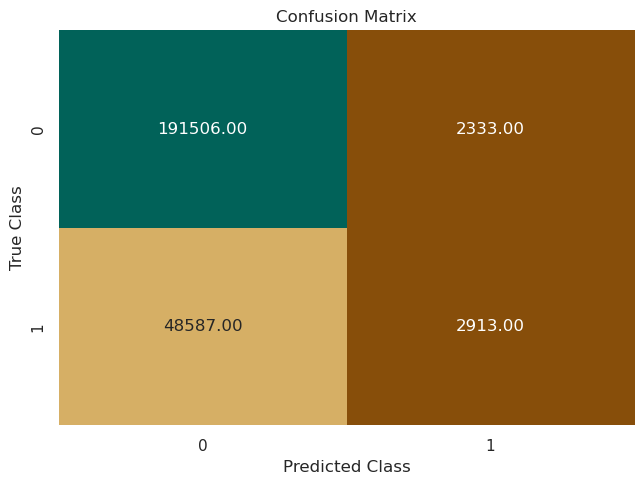

In [57]:
plot_confusion_matrix(test_labels_v2, target_predicted_v2)

Sensitivity or TPR: 5.656310679611651 %
Specificity or TNR: 98.79642383627649 %
Precision: 55.5280213495997 %
Negative Predictive Value: 79.7632584040351 %
False Positive Rate: 1.2035761637235025 %
False Negative Rate: 94.34368932038835 %
False Discovery Rate: 44.47197865040031 %
Accuracy: 79.2450446117413 %
Validation AUC: 0.5222636725794407


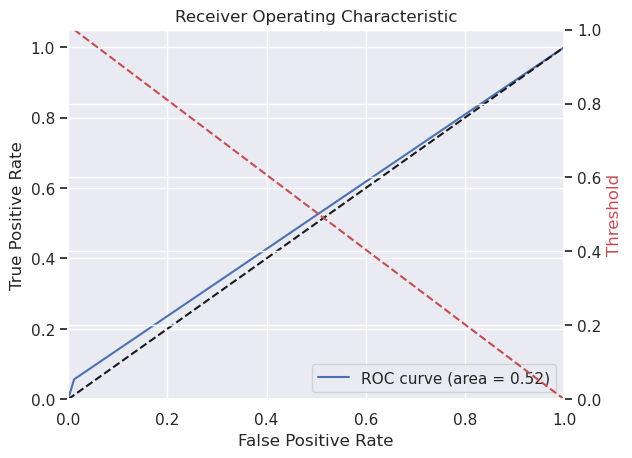

In [54]:
plot_roc(test_labels_v2, target_predicted_v2)

### On Premises and Cloud Model Comparison

| Metric                    | Model 1 (On-Premise) | Optimized Model (On-Premise) | SageMaker Linear Estimator Optimized Model | SageMaker XGBoost Optimized Model  |
|---------------------------|----------------------|-------------------------------|--------------------------------------------|------------------------------------|
| **Accuracy**              | 79 %                | 62 %                           | 79.25 %                                    | 79.25 %                              |
| **Sensitivity (TPR)**     | 0.00 %              | 58.00 %                       | 5.66 %                                     | 5.66 %                             |
| **Specificity (TNR)**     | 100.00 %            | 62.00 %                       | 98.80 %                                    | 98.80 %                            |
| **Precision**             | 52.00 %             | 29.00 %                       | 55.53 %                                    | 55.53 %                            |

### Comparison Between Two Approaches

#### OnCloud Approach

One thing I liked about Amazon SageMaker the most is how it manages the dependencies, environments. It makes it much easier to work to get started. You have your environment setup and you can get started quickly. Unlike on local machine where you need to setup Python virtual environment, then Jupyter server and kernel. Managing python's dependencies is an issue if you are not using virtual environment or conda.

However, I find the lack of debugging option annoying in Amazon SageMaker. Maybe, my workflow using cloud is not that optimized because I am new to this approach, nonethless, I find making changes much easier on my local machine setup especially in VSCode.

#### On-premise Approach

On the other hand, a local machine setup often requires more effort to configure. Setting up a Python virtual environment, launching a Jupyter server, and managing dependencies can be cumbersome, especially if you're not using tools like virtualenv or Conda. Dependency conflicts are more likely on a local setup, and without careful management, they can disrupt workflows and create issues over time. However, with tools like VSCode, working locally offers more flexibility and a familiar development environment, especially for debugging.

#### Conclusion

While my cloud-based workflow is still evolving, especially as I gain experience with SageMaker, I recognize that each approach has its advantages. Amazon SageMaker excels in providing a ready-to-use, scalable environment, making it a powerful choice for projects where rapid setup and large-scale resources are essential